# **Predicting credit risk for a bank customer**


# **1. Dataset description** 

<b>German credit data: </b></br>
<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text - little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in months)<br>
<b>Purpose</b>(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)<br>
<b>Risk </b> (Value target - Good or Bad Risk)<br>

<a id="Libraries"></a> <br>
# **2. Libraries and data** 

In [1]:
import warnings 
from collections import Counter 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/file/d/1w6YFhjiFCruL_EHyN125nT4nPplqm1nm/view?usp=sharing' 

id = link.split("/")[-2]
filename= 'german_credit_data.csv'
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(filename)

In [4]:
df_credit = pd.read_csv(filename, index_col=0)

<a id="Known"></a> <br>
# **3. First look at the data** 

In [5]:
#Searching for null values,data types and shape
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [6]:
#Looking at unique values
df_credit.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

In [7]:
#Looking at a data sample
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [8]:
# Looking at the target variable to identify imbalance
df_credit['Risk'].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

# **4. Feature Engineering** <a id="Feature Engineering"></a> <br>

## Null treatement

In [9]:
df_credit['Checking account'].value_counts()

little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [10]:
# Null treatement
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

In [11]:
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,no_inf,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,no_inf,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Treatement of Categorical variables

In [12]:
df_credit.select_dtypes(['object']).columns

Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose',
       'Risk'],
      dtype='object')

In [13]:
df_credit.select_dtypes(['category']).columns

Index([], dtype='object')

In [14]:
categ = list(df_credit.select_dtypes(['object']).columns | df_credit.select_dtypes(['category']).columns)
print(categ)

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']


In [15]:
print('Data frame shape before Categorical Values encoding: ',df_credit.shape)
df_credit = pd.get_dummies(data=df_credit, columns=categ)
print('Data frame shape after Categorical Values encoding: ',df_credit.shape)

Data frame shape before Categorical Values encoding:  (1000, 10)
Data frame shape after Categorical Values encoding:  (1000, 28)


In [16]:
df_credit.head()

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_no_inf,Saving accounts_quite rich,Saving accounts_rich,Checking account_little,Checking account_moderate,Checking account_no_inf,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_bad,Risk_good
0,67,2,1169,6,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,22,2,5951,48,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,49,1,2096,12,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3,45,2,7882,42,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
4,53,2,4870,24,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0


In [17]:
del df_credit['Risk_good']

## Looking at the correlation of the data

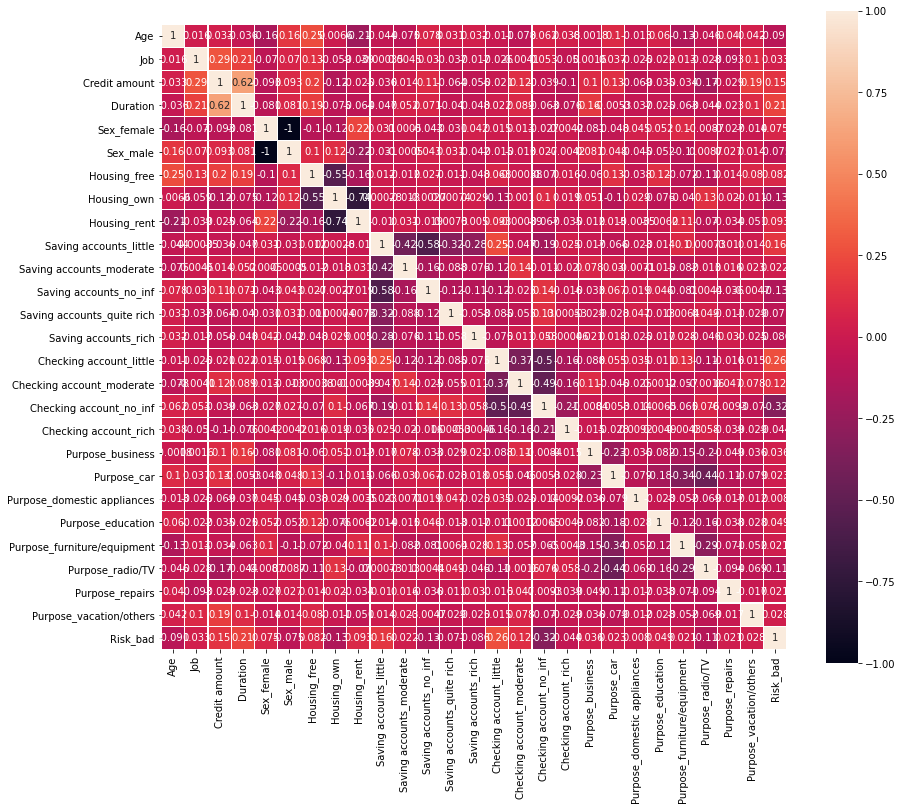

In [18]:
plt.figure(figsize=(14,12))
sns.heatmap(df_credit.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

In [19]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [20]:
corr_features = correlation(df_credit, 0.7)

In [21]:
print(corr_features)

{'Housing_rent', 'Sex_male'}


In [22]:
for column in corr_features:
  df_credit.drop(column, axis=1,inplace=True)

Train/Test split and Scaling

In [23]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report, fbeta_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [24]:
target = 'Risk_bad'
predictor = df_credit.drop([target], axis=1).columns

In [25]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_credit[predictor], df_credit[target], test_size = 0.2, random_state=42)

Scale input for distance-based models (Logistic Regression, KMeans, Support Vector Classifier)

In [26]:
min_max_scaler = preprocessing.MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

Model evaluation functions

In [27]:
# Evaluate results based on the confusion matrix
def plot_cm(model, X_test, y_test):
  plot_confusion_matrix(model, X_test, y_test, values_format='d', cmap='Blues')  
  plt.show()

In [28]:
# Evaluate model performance
def clasif_report(y_test,y_pred):
  print(classification_report(y_test, y_pred))

In [29]:
# Determine model robustness
def roc_auc(model, X_train, y_train, y_test, y_pred, n_splits):
  roc_auc_test = metrics.roc_auc_score(y_test, y_pred, average='micro')
  roc_auc_cv = cross_val_score(estimator = model, X = X_train, y = y_train, scoring = 'roc_auc', cv = n_splits)
  roc_auc_cv_mean = roc_auc_cv.mean()
  roc_auc_cv_std = roc_auc_cv.std()
  
  print('Test ROC AUC           : {:.4f}'.format(roc_auc_test))
  print('Cross-val ROC AUC mean : {:.4f}'.format(roc_auc_cv_mean))
  print('Cross-val ROC AUC std  : {:.4f}'.format(roc_auc_cv_std))

In [30]:
#Plotting the ROC curve
def plot_roc_curve(model, X_test, y_test):
  y_pred_prob = model.predict_proba(X_test)[:,1]              # Predict probabilities
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)       # Generate ROC curve values: fpr, tpr, thresholds
  
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

Logistic regression

In [32]:
# import libraries
from sklearn.linear_model import LogisticRegression

In [51]:
model_LR = LogisticRegression(random_state=42, solver='newton-cg')

In [52]:
model_LR.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
y_pred = model_LR.predict(X_test_scaled)

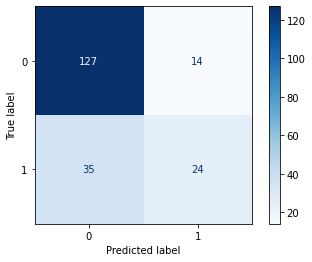

In [43]:
# Evaluate results based on the confusion matrix
plot_cm(model_LR, X_test_scaled, y_test)

In [44]:
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       141
           1       0.63      0.41      0.49        59

    accuracy                           0.76       200
   macro avg       0.71      0.65      0.67       200
weighted avg       0.74      0.76      0.74       200



In [53]:
roc_auc(model_LR, X_train_scaled, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6537
Cross-val ROC AUC mean : 0.7560
Cross-val ROC AUC std  : 0.0383


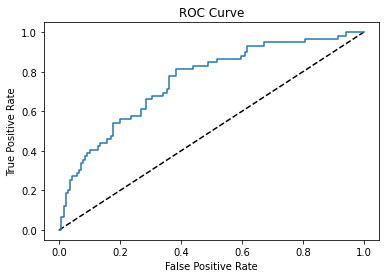

In [46]:
plot_roc_curve(model_LR, X_test_scaled, y_test)

In [54]:
# Print intercept and coefficients
print ('Model intercept: '+str(model_LR.intercept_))

# model coefficients
odds = np.exp(model_LR.coef_[0])
pd.DataFrame(odds, 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

# For every one-unit increase in [X variable], the odds that the observation is 
# in (y class) are [coefficient] times as large as the odds that the observation 
# is not in (y class) when all other variables are held constant

Model intercept: [-1.22668641]


,coef
Duration,3.996211
Checking account_little,2.165771
Credit amount,1.771703
Purpose_education,1.604785
Sex_female,1.466237
Saving accounts_moderate,1.424383
Saving accounts_little,1.421493
Job,1.408022
Checking account_moderate,1.388656
Purpose_repairs,1.214130


K-Nearest Neighbors Classifier

In [55]:
# import libraries
from sklearn.neighbors import KNeighborsClassifier

In [56]:
model_KNN = KNeighborsClassifier()

In [58]:
model_KNN.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [59]:
y_pred = model_KNN.predict(X_test_scaled)

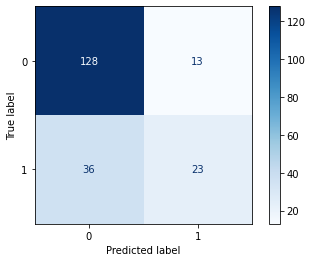

In [60]:
plot_cm(model_KNN, X_test_scaled, y_test)

In [61]:
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       141
           1       0.64      0.39      0.48        59

    accuracy                           0.76       200
   macro avg       0.71      0.65      0.66       200
weighted avg       0.74      0.76      0.73       200



In [62]:
roc_auc(model_KNN, X_train_scaled, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6488
Cross-val ROC AUC mean : 0.6921
Cross-val ROC AUC std  : 0.0469


SVC

In [64]:
from sklearn.svm import SVC

In [65]:
# train the model
model_SVC = SVC(kernel='rbf', gamma='auto', probability=True, random_state=42)
model_SVC.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [66]:
y_pred = model_SVC.predict(X_test_scaled)

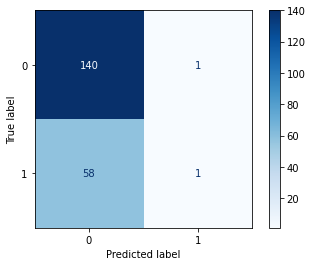

In [73]:
plot_cm(model_SVC, X_test_scaled, y_test)

In [68]:
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       141
           1       0.50      0.02      0.03        59

    accuracy                           0.70       200
   macro avg       0.60      0.50      0.43       200
weighted avg       0.65      0.70      0.59       200



In [71]:
roc_auc(model_SVC, X_train_scaled, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.5049
Cross-val ROC AUC mean : 0.7476
Cross-val ROC AUC std  : 0.0418


Decision Tree 

In [75]:
# import libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [95]:
model_DT = DecisionTreeClassifier(max_depth=4, random_state=42)
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [96]:
y_pred = model_DT.predict(X_test)

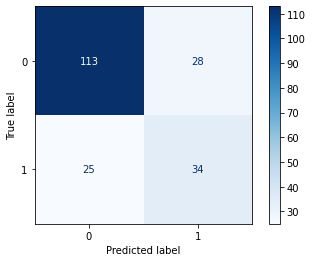

In [97]:
plot_cm(model_DT, X_test, y_test)

In [98]:
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       141
           1       0.55      0.58      0.56        59

    accuracy                           0.73       200
   macro avg       0.68      0.69      0.69       200
weighted avg       0.74      0.73      0.74       200



In [99]:
roc_auc(model_DT, X_train, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6888
Cross-val ROC AUC mean : 0.6806
Cross-val ROC AUC std  : 0.0370


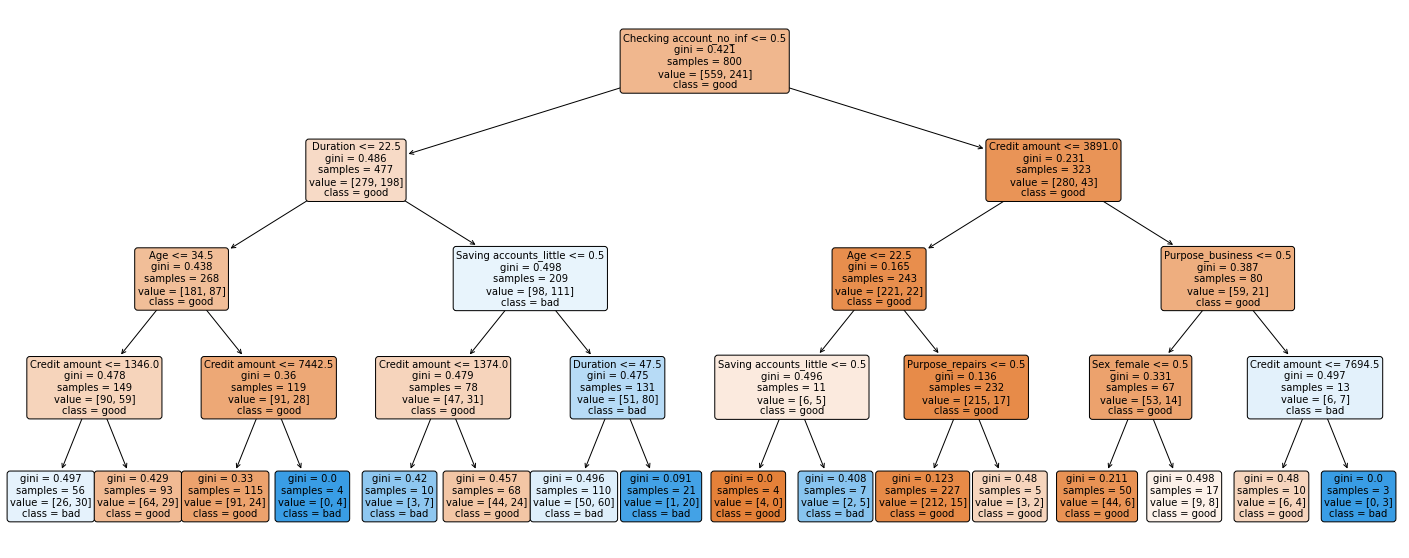

In [100]:
# plot tree
plt.figure(figsize=(25,10))  # set plot size (denoted in inches)
tree.plot_tree(model_DT, fontsize=10,
               feature_names=X_train.columns, class_names=['good','bad'],
               filled=True, rounded=True)
plt.show()

In [82]:
from sklearn.tree import export_text
r = export_text(model_DT, feature_names=list(X_train.columns))
print(r)

|--- Checking account_no_inf <= 0.50
|   |--- Duration <= 22.50
|   |   |--- Age <= 34.50
|   |   |   |--- Credit amount <= 1346.00
|   |   |   |   |--- class: 1
|   |   |   |--- Credit amount >  1346.00
|   |   |   |   |--- class: 0
|   |   |--- Age >  34.50
|   |   |   |--- Credit amount <= 7442.50
|   |   |   |   |--- class: 0
|   |   |   |--- Credit amount >  7442.50
|   |   |   |   |--- class: 1
|   |--- Duration >  22.50
|   |   |--- Saving accounts_little <= 0.50
|   |   |   |--- Credit amount <= 1374.00
|   |   |   |   |--- class: 1
|   |   |   |--- Credit amount >  1374.00
|   |   |   |   |--- class: 0
|   |   |--- Saving accounts_little >  0.50
|   |   |   |--- Duration <= 47.50
|   |   |   |   |--- class: 1
|   |   |   |--- Duration >  47.50
|   |   |   |   |--- class: 1
|--- Checking account_no_inf >  0.50
|   |--- Credit amount <= 3891.00
|   |   |--- Age <= 22.50
|   |   |   |--- Saving accounts_little <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Saving accounts

In [102]:
from sklearn.ensemble import RandomForestClassifier

In [104]:
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [105]:
y_pred = model_RF.predict(X_test)

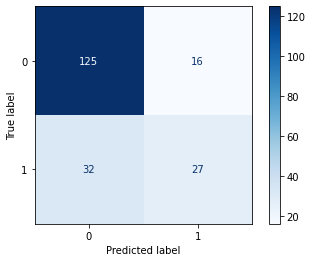

In [106]:
plot_cm(model_RF, X_test, y_test)

In [107]:
# Evaluate model performance
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       141
           1       0.63      0.46      0.53        59

    accuracy                           0.76       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.75      0.76      0.75       200



In [108]:
roc_auc(model_RF, X_train, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6721
Cross-val ROC AUC mean : 0.7427
Cross-val ROC AUC std  : 0.0344


XGBoost

In [111]:
from xgboost import XGBClassifier

In [114]:
model_XGB = XGBClassifier(random_state=42)
model_XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [115]:
y_pred = model_XGB.predict(X_test)

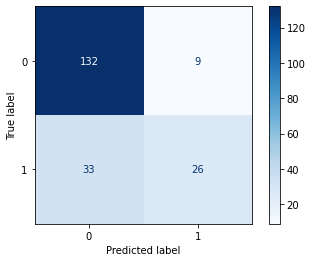

In [116]:
plot_cm(model_XGB, X_test, y_test)

In [117]:
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.80      0.94      0.86       141
           1       0.74      0.44      0.55        59

    accuracy                           0.79       200
   macro avg       0.77      0.69      0.71       200
weighted avg       0.78      0.79      0.77       200



In [118]:
roc_auc(model_XGB, X_train, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6884
Cross-val ROC AUC mean : 0.7389
Cross-val ROC AUC std  : 0.0381


In [119]:
def run_models(X_train, X_train_scaled, y_train, n_splits):
  # prepare models
  models = []
  model_names = ['LR','KNN','SVC','DT','RF','XGB']
  models.append(('Logistic Regression      ', model_LR))
  models.append(('KNeighbors Classifier    ', model_KNN))
  models.append(('Support Vector Classifier', model_SVC))
  models.append(('Decision Tree Classifier ', model_DT))
  models.append(('Random Forest Classifier ', model_RF))
  models.append(('XGBoost Classifier       ', model_XGB))
  
  # evaluate each model in turn
  results = []
  names = []
  scoring = 'roc_auc'
  
  print('Model                     | ROC-AUC  | ROC-AUC std')
  for name, model in models:
    kfold = KFold(n_splits=n_splits)
    if name in ['DT', 'RF','XGB']:
      X_train_scaled = X_train
    cv_results = cross_val_score(model, X_train_scaled, y_train, 
                                 cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s | %f | (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
  print('')
  
  # boxplot model comparison
  fig = plt.figure(figsize=(8,4))
  fig.suptitle('Models Performance Comparison')
  ax = fig.add_subplot(111)
  plt.boxplot(results)
  ax.set_xticklabels(model_names)
  plt.show()

Model                     | ROC-AUC  | ROC-AUC std
Logistic Regression       | 0.751090 | (0.041063)
KNeighbors Classifier     | 0.698074 | (0.069485)
Support Vector Classifier | 0.741755 | (0.045317)
Decision Tree Classifier  | 0.708569 | (0.057205)
Random Forest Classifier  | 0.739967 | (0.056051)
XGBoost Classifier        | 0.750979 | (0.057132)



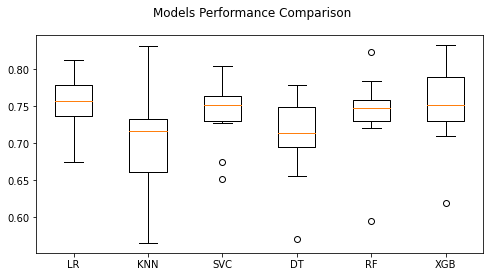

In [120]:
run_models(X_train, X_train_scaled, y_train,10)

In [121]:
classifier = model_XGB
params = {"learning_rate"    : [ 0.05, 0.10, 0.15 ] ,
          "max_depth"        : [ 10, 12, 15],
          "min_child_weight" : [ 3, 5, 7 ],
          "gamma"            : [ 0.0, 0.1, 0.2 ],
          "colsample_bytree" : [ 0.3, 0.5 , 0.7 ] }

grid_search = GridSearchCV(classifier, param_grid=params, cv=5, scoring='roc_auc', n_jobs=32,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:   22.3s
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:   34.1s
[Parallel(n_jobs=32)]: Done 448 tasks      | elapsed:   48.7s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:  1.2min
[Parallel(n_jobs=32)]: Done 1088 tasks      | elapsed:  1.7min
[Parallel(n_jobs=32)]: Done 1215 out of 1215 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=32,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.15],
    

In [122]:
print('Best score     :',grid_search.best_score_)
print('Best parameters:',grid_search.best_params_)
classifier = grid_search.best_estimator_

Best score     : 0.760425428617393
Best parameters: {'colsample_bytree': 0.3, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 5}


In [123]:
y_pred = classifier.predict(X_test)

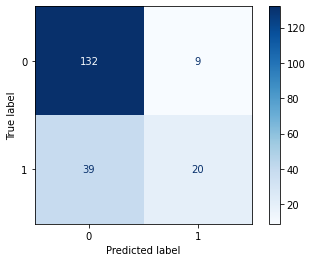

In [124]:
plot_cm(classifier, X_test, y_test)

In [125]:
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       141
           1       0.69      0.34      0.45        59

    accuracy                           0.76       200
   macro avg       0.73      0.64      0.65       200
weighted avg       0.75      0.76      0.73       200



In [126]:
roc_auc(classifier, X_train, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6376
Cross-val ROC AUC mean : 0.7604
Cross-val ROC AUC std  : 0.0276


In [127]:
def treshold_calc(new_treshold, classifier, X_test, y_test):
  y_pred = classifier.predict(X_test)
  y_pred_tr = ((classifier.predict_proba(X_test)[:, 1])>= new_treshold).astype(int)
  print('Valuation for test data only, standard treshold')
  print("Recall: %.4f" %recall_score(y_test,y_pred)," | ROC AUC: %.4f" %roc_auc_score(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  print("------------------------------------------------------")
  print('Valuation for test data only, treshold at', new_treshold)
  print("Recall: %.4f" % recall_score(y_test,y_pred_tr)," | ROC AUC: %.4f" % roc_auc_score(y_test, y_pred_tr))
  print(confusion_matrix(y_test, y_pred_tr))
  print(classification_report(y_test, y_pred_tr))

In [128]:
from pylab import *

In [129]:
# predict probabilities
y_pred_proba = classifier.predict_proba(X_test)

In [130]:
probs = y_pred_proba[:, 1]

In [132]:
# define thresholds (test all thresholds between 0.0 and 1.0 with a step size of 0.001)
thresholds = arange(0, 1, 0.001)

In [133]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [134]:
# evaluate each threshold
scores = [roc_auc_score(y_test, to_labels(probs, t)) for t in thresholds]

In [135]:
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, ROC-AUC Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.291, ROC-AUC Score=0.73951


In [136]:
treshold_calc(ix/1000, classifier, X_test, y_test)

Valuation for test data only, standard treshold
Recall: 0.3390  | ROC AUC: 0.6376
[[132   9]
 [ 39  20]]
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       141
           1       0.69      0.34      0.45        59

    accuracy                           0.76       200
   macro avg       0.73      0.64      0.65       200
weighted avg       0.75      0.76      0.73       200

------------------------------------------------------
Valuation for test data only, treshold at 0.291
Recall: 0.7627  | ROC AUC: 0.7395
[[101  40]
 [ 14  45]]
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       141
           1       0.53      0.76      0.62        59

    accuracy                           0.73       200
   macro avg       0.70      0.74      0.71       200
weighted avg       0.78      0.73      0.74       200



In [137]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(sampling_strategy='minority', random_state = 42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 

print('Before OverSampling, the shape of X_train: {}'.format(X_train.shape)) 
print('Before OverSampling, the shape of y_train: {} \n'.format(y_train.shape)) 
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))   
print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape)) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, the shape of X_train: (800, 24)
Before OverSampling, the shape of y_train: (800,) 

Before OverSampling, counts of label '1': 241
Before OverSampling, counts of label '0': 559 

After OverSampling, the shape of X_train: (1118, 24)
After OverSampling, the shape of y_train: (1118,) 

After OverSampling, counts of label '1': 559
After OverSampling, counts of label '0': 559


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [139]:
model_XGB_SMOTE = classifier
model_XGB_SMOTE.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [140]:
y_pred = model_XGB_SMOTE.predict(X_test.values)

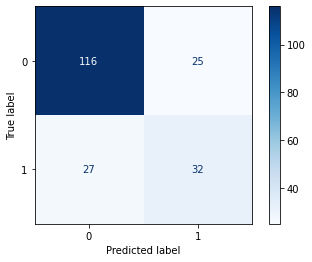

In [141]:
plot_cm(model_XGB_SMOTE, X_test.values, y_test)

In [142]:
roc_auc(model_XGB_SMOTE, X_train_res, y_train_res, y_test, y_pred, 5)

Test ROC AUC           : 0.6825
Cross-val ROC AUC mean : 0.8849
Cross-val ROC AUC std  : 0.0957
